In [ ]:
import pandas as pd
import scanpy as sc
import anndata as ad
import utils as ut
import cupy as cp
import cuml
from cuml.preprocessing import StandardScaler
from cuml.decomposition import PCA


INPUT_DIR = "./data/raw/"
OUTPUT_DIR = "./data/output/"

# Step 1: Load the CSV file
# df = pd.read_csv("8_SN141_slides2_ROI-03.csv")
df = ut.combine_feature_files(
    INPUT_DIR,
    feature_files=[
        "8_SN141_slides2_ROI-03.csv", 
        "7_SN141_slides1_ROI-07.csv",
        "9_SN141_slides2_ROI-06.csv"
        "10_ROI-25.csv"], 
    region_list=[
        "R3-amd",
        "R7-amd",
        
        "R10-healthy"]
    )


# Step 2: Separate features and metadata
meta_column_names = ["Cell Id", "Nuc X", "Nuc Y Inv", "region_num", "unique_region"]
feature_cols = df.columns.difference(meta_column_names)
features = df[feature_cols].copy()
metadata = df[meta_column_names].copy()

# Step 3: Normalize and scale features using cuML
scaler = StandardScaler()
scaled_features_gpu = scaler.fit_transform(cp.asarray(features.values))

# Step 4: Create an AnnData object
adata = ad.AnnData(X=cp.asnumpy(scaled_features_gpu))  # AnnData expects NumPy arrays
adata.obs = metadata

# Step 5: Compute PCA using cuML
pca_gpu = PCA(n_components=50, svd_solver='full')
adata.obsm["X_pca"] = pca_gpu.fit_transform(scaled_features_gpu).get()

# Step 6: Compute neighborhood graph (Scanpy still uses CPU)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

# Step 7: Apply Leiden clustering
sc.tl.leiden(adata, resolution=1.0)



# Step 8: Inspect cluster assignments
print(adata.obs['leiden'].value_counts())

# Optional: Save results
adata.obs.to_csv("cluster_assignments.csv", index=False)

leiden
0     2168
1     2060
2     1901
3     1901
4     1646
5     1596
6     1535
7     1273
8     1179
9      956
10     868
11     736
12     601
13     541
14     498
15     437
16     343
17     323
18     303
19     199
20     197
21     165
22      91
Name: count, dtype: int64


In [14]:
df.columns[df.isna().any()].tolist()

[]

In [15]:
# Split AnnData by 'sample' column
split_dict = {
    sample: adata[adata.obs['unique_region'] == sample].copy()
    for sample in adata.obs['unique_region'].unique()
}

/home/hp/projects/multiplex_imaging_analysis/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/hp/projects/multiplex_imaging_analysis/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/hp/projects/multiplex_imaging_analysis/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [16]:
split_dict

{'R3-amd': AnnData object with n_obs × n_vars = 7625 × 89
     obs: 'Cell Id', 'Nuc X', 'Nuc Y Inv', 'region_num', 'unique_region', 'leiden'
     uns: 'pca', 'neighbors', 'leiden'
     obsm: 'X_pca'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 'R7-amd': AnnData object with n_obs × n_vars = 6836 × 89
     obs: 'Cell Id', 'Nuc X', 'Nuc Y Inv', 'region_num', 'unique_region', 'leiden'
     uns: 'pca', 'neighbors', 'leiden'
     obsm: 'X_pca'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 'R10-healthy': AnnData object with n_obs × n_vars = 7056 × 89
     obs: 'Cell Id', 'Nuc X', 'Nuc Y Inv', 'region_num', 'unique_region', 'leiden'
     uns: 'pca', 'neighbors', 'leiden'
     obsm: 'X_pca'
     varm: 'PCs'
     obsp: 'distances', 'connectivities'}

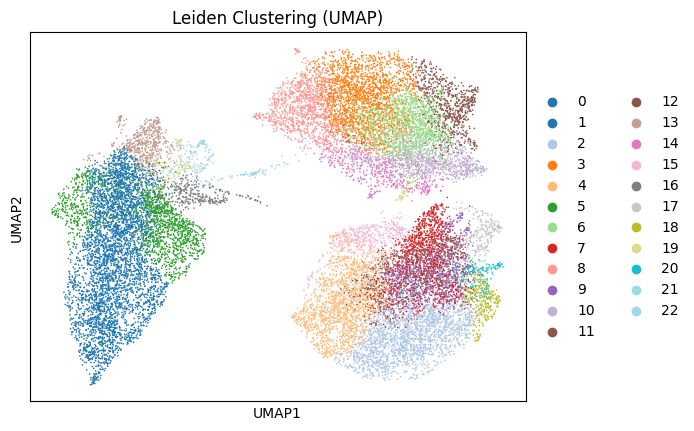

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Compute UMAP embedding
sc.tl.umap(adata)

# Step 2: Plot UMAP colored by Leiden clusters
sc.pl.umap(adata, color='leiden', title='Leiden Clustering (UMAP)', palette='tab20', save=False)



Plot for region R3-amd


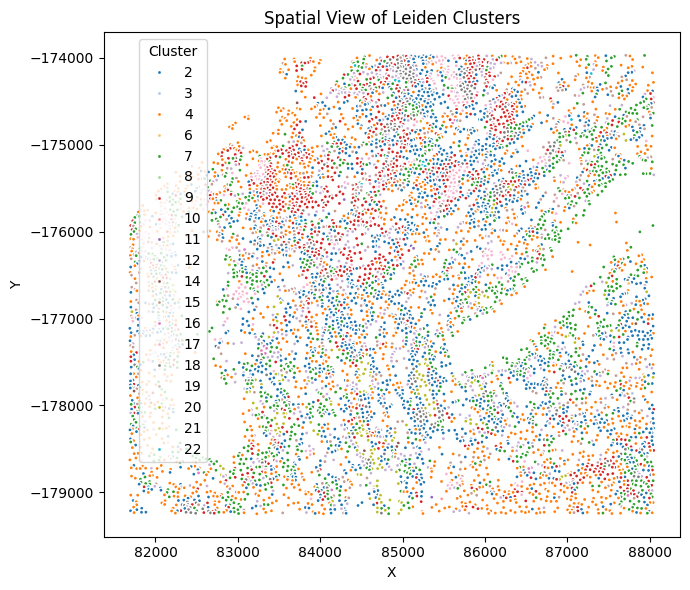

Plot for region R7-amd


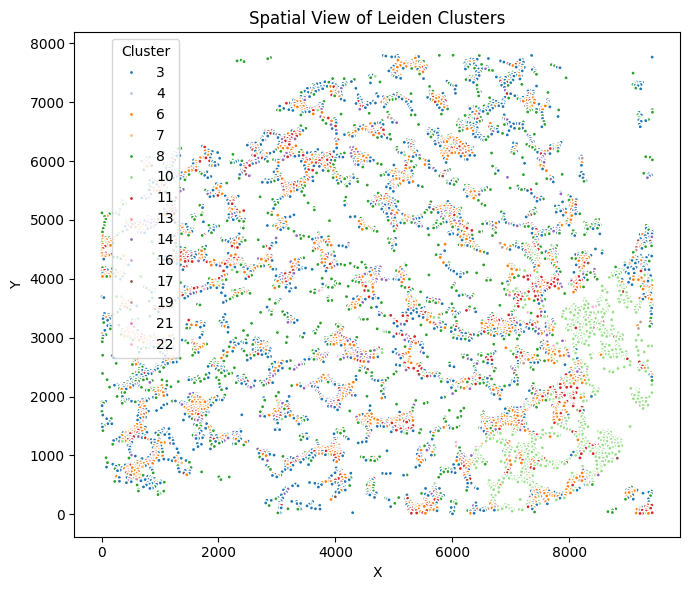

Plot for region R10-healthy


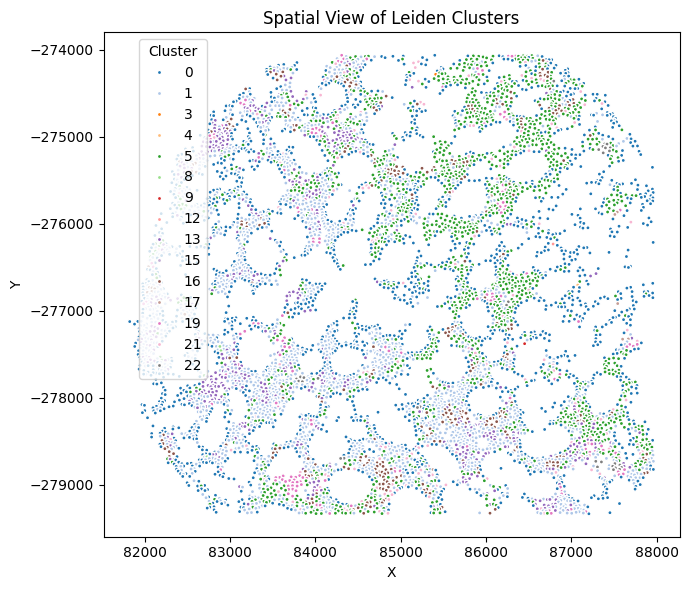

In [18]:
# Optional: Plot spatial coordinates colored by cluster
def plot_spatial_coordinates(adata):
    plt.figure(figsize=(7, 6))
    sns.scatterplot(
        x=adata.obs['Nuc X'],
        y=adata.obs['Nuc Y Inv'],
        hue=adata.obs['leiden'],
        palette='tab20',
        s=9,
        linewidth=-1
    )
    plt.title('Spatial View of Leiden Clusters')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(title='Cluster', bbox_to_anchor=(0.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

for region_name, data in split_dict.items():
    print(f"Plot for region {region_name}")
    plot_spatial_coordinates(data)
    data.obs.to_csv(f"{region_name}_cluster_assignments.csv", index=False)